# Posprocessing a run

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.6

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.6


In [3]:
import lenses
import jax
import numpy as np
from jax import numpy as jnp
from typing import cast
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from tqdm import trange

from flox.util import key_chain
from flox.flow import Pipe, Inverted, bind#, Transform, Transformed
import equinox as eqx
from functools import partial

from rigid_flows.flow import build_flow, RigidWithAuxiliary
from rigid_flows.data import Data, DataWithAuxiliary
from rigid_flows.density import OpenMMDensity
from rigid_flows.specs import FlowSpecification, CouplingSpecification, ExperimentSpecification
# from rigid_flows.density import PositionPrior, RotationPrior
from rigid_flows.utils import jit_and_cleanup_cache, scanned_vmap

chain = key_chain(42)

2023-01-30 11:47:21.361269: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64
2023-01-30 11:47:21.361834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64
2023-01-30 11:47:21.361846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
#set bigger font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16

plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)   # fontsize of the figure title

In [5]:
def count_params(model):
    return jax.tree_util.tree_reduce(
        lambda s, n: s + n.size if eqx.is_array(n) else s, model, jnp.zeros((), dtype=jnp.int32)).item()

def ess(logw):
    return jnp.exp(2*jax.scipy.special.logsumexp(logw)-jax.scipy.special.logsumexp(2*logw))

In [6]:
logdir_path = '/group/ag_cmb/scratch/jonkhler/so3-flow/water/'
# logdir_path += 'tuna_N16_T100_noaux_2023-01-24_16:02:39'
# logdir_path += 'antelope_N16_T50_noaux_2023-01-25_08:08:54'
logdir_path += 'dragonfly_N128_T100_noaux_2023-01-24_22:33:59'

stage = 0
epoch = 9
print(f'+++ epoch {epoch} +++')
specs_path = f"{logdir_path}/config.yaml"
pretrained_model_path = f'{logdir_path}/training_stage_{stage}/epoch_{epoch}/model.eqx'
print(pretrained_model_path)

specs = ExperimentSpecification.load_from_file(specs_path)
specs = lenses.bind(specs).model.base.path.set(specs.model.base.path+'/eval_100')

base = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.base)
target = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.target)
model = base.omm_model.model

data = Data.from_specs(specs.model.target, target.box)
flow = build_flow(next(chain), specs.model.auxiliary_shape, specs.model.flow)
flow = cast(Pipe[DataWithAuxiliary, RigidWithAuxiliary], eqx.tree_deserialise_leaves(pretrained_model_path, flow))

training_data_size = 100_000 if specs.model.base.num_samples is None else specs.model.base.num_samples
print(f'tot flow parameters: {count_params(flow):_}')
print(f'MD training datapoints = {training_data_size:_}')
print(f'MD eval datapoints = {base.data.pos.shape[0]:_}')
print(f'batchs per epoch = {specs.train[0].num_iters_per_epoch}')
print(f'batch size = {specs.train[0].num_samples}')
print(f'data fraction: {specs.train[0].num_epochs*specs.train[0].num_samples*specs.train[0].num_iters_per_epoch/training_data_size}')

+++ epoch 9 +++
/group/ag_cmb/scratch/jonkhler/so3-flow/water/dragonfly_N128_T100_noaux_2023-01-24_22:33:59/training_stage_0/epoch_9/model.eqx
tot flow parameters: 7_487_568
MD training datapoints = 100_000
MD eval datapoints = 100_000
batchs per epoch = 5000
batch size = 32
data fraction: 16.0


In [7]:
reference_deltaF, reference_deltaF_std = None, None

if specs.model.base.temperature == specs.model.target.temperature:
    reference_deltaF, reference_deltaF_std = 0, 0
elif specs.model.base.num_molecules == 16:
    if specs.model.base.temperature == 250 and specs.model.target.temperature == 100:
        label_txt = 'a)'
        reference_deltaF, reference_deltaF_std = -666.09897990553, 0.0558899 # MBAR, 10_000 samples, 5 replicas
    elif specs.model.base.temperature == 250 and specs.model.target.temperature == 50:
        label_txt = 'b)'
        reference_deltaF, reference_deltaF_std = -1818.2199636389134, 0.0632776 # MBAR, 10_000 samples, 10 replicas
elif specs.model.base.num_molecules == 128:
    if specs.model.base.temperature == 250 and specs.model.target.temperature == 100:
        label_txt = 'c)'
        reference_deltaF, reference_deltaF_std = -5314.324317927606, 0.0944014 # MBAR, 10_000 samples, 10 replicas
    elif specs.model.base.temperature == 250 and specs.model.target.temperature == 50:
        reference_deltaF, reference_deltaF_std = -14522.10556489954, 0.135 # MBAR, 10_000 samples, 20 replicas

reference_deltaF, reference_deltaF_std

(-5314.324317927606, 0.0944014)

In [8]:
sc = model.n_waters
test_subplots = False

In [9]:
import json

with open(logdir_path+'/loss.json', "r") as f:
    loss_info = np.array(json.load(f))[:,1:]

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg

def plot_loss():
    plt.plot(loss_info[:,0], loss_info[:,1]/sc)
    plt.axhline(reference_deltaF/sc, c='k', ls=':', label='$\Delta F$')
    # plt.xlim(0, loss_info[:,0].max()+loss_info[:,0].min())
    plt.xlim(1e2, loss_info[:,0].max()+loss_info[:,0].min())
    plt.xscale('log')
    plt.ylabel('loss')
    plt.xlabel('steps')
    plt.legend(loc='lower left')

    plt.text(-0.2, 1.0, label_txt, transform=plt.gca().transAxes, fontdict={'fontsize': 'large'})
    
    img = mpimg.imread(f'data/water/iceXI-N{model.n_waters}.png')
    subax = inset_axes(plt.gca(), width="50%", height="60%", loc=1)
    subax.imshow(img)
    subax.axis('off')
    
if test_subplots:
    plot_loss()
    plt.show()

In [11]:
datafilename = logdir_path+'/fig3-data'

try:
    data = np.load(datafilename+'.npz')
    base_pos = data['base_pos']
    base_ene = data['base_ene']
    mapped_pos = data['mapped_pos']
    mapped_ene = data['mapped_ene']
    target_pos = data['target_pos']
    target_ene = data['target_ene']
    weights = data['weights']
    
except FileNotFoundError:
    num_samples = 100_000
    batch_size = 128

    print('sample base')
    keys = jax.random.split(next(chain), num_samples)
    base_tr = scanned_vmap(base.sample, batch_size)(keys)
    base_pos = np.array(base_tr.obj.pos.reshape(-1, model.n_atoms, 3))
    base_ene = np.array(base_tr.ldj * base.omm_model.kbT)

    print('map base')
    mapped_tr = scanned_vmap(flow.forward, batch_size)(base_tr.obj)
    mapped_pos = np.array(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3))

    print('compute weights')
    ## NB: base_tr.ldj = jax.vmap(base.potential)(base_tr.obj)
    mapped_ene_tg = scanned_vmap(target.potential, batch_size)(mapped_tr.obj)
    mapped_ene = np.array(mapped_ene_tg * target.omm_model.kbT)

    logw = base_tr.ldj + mapped_tr.ldj - mapped_ene_tg
    weights = np.array(jnp.exp(logw-jax.scipy.special.logsumexp(logw)))

    print('sample target')
    keys = jax.random.split(next(chain), num_samples)
    target_tr = scanned_vmap(target.sample, batch_size)(keys)
    target_pos = np.array(target_tr.obj.pos.reshape(-1, model.n_atoms, 3))
    target_ene = np.array(target_tr.ldj * target.omm_model.kbT)

    def plot_2Dview(data_tr: DataWithAuxiliary, title: str, toPBC: bool = True, skip: int = 100):
        model.plot_2Dview(data_tr.obj.pos.reshape(-1, model.n_atoms, 3)[::skip], toPBC=toPBC, title=title)

    plot_2Dview(base_tr, title='base')
    plot_2Dview(mapped_tr, title='mapped')
    plot_2Dview(target_tr, title='target')

    plt.hist(jnp.exp(logw - logw.max()), bins=100)
    plt.yscale('log')
    plt.show()
    print(f'ESS = {ess(logw):g}  ->  {ess(logw)/len(logw):.2%}')

    ## TFEP
    deltaF = (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()
    print(f'Estimated deltaF from LFEP = {deltaF/sc:g}')
    if reference_deltaF is not None:
        print(f'          Reference deltaF = {reference_deltaF/sc:g}')

In [12]:
# bins = np.linspace(target_ene.min(), np.percentile(base_ene, 99.9), 200)/sc
# if model.n_waters == 16:
#     bins = np.linspace(-20.5, -17, 200)*model.n_waters*3/sc
# if model.n_waters == 128:
#     bins = np.linspace(-20, -17.75, 200)*model.n_waters*3/sc
bins = np.linspace(-20.5, -17.5, 100)*model.n_waters*3/sc
hist_kwargs = {"bins": bins, "density": True, "alpha": 0.5}

def plot_energy():
    plt.hist(base_ene/sc, **hist_kwargs, label='base')
    plt.hist(mapped_ene/sc, **hist_kwargs, label='mapped')
    plt.hist(target_ene/sc, **hist_kwargs, label='target')
    if model.n_waters == 128: #ESS is small, histogram resolution must be smaller
        mybins = 75
    else:
        mybins = hist_kwargs['bins']
    plt.hist(mapped_ene/sc, weights=weights, label='reweighted', bins=mybins, density=True, histtype='step')
    plt.xlabel('potential energy / N [kJ/mol]')
    # plt.xticks(np.arange(-21,-16)*model.n_waters*3/sc)
    plt.xlim(bins[0], bins[-1])
    plt.ylabel('density')
    plt.legend()

if test_subplots:
    plot_energy()
    plt.show()

In [13]:
import mdtraj as md

n_bins = 200
# r_range = [0.2, min(np.round(np.diag(model.box).min() * 10) / 10, 1)]
r_range = [0.2, 0.7]
ij = model.mdtraj_topology.select_pairs("name == O", "name == O")

base_rdf = md.compute_rdf(model.get_mdtraj(base_pos), ij, r_range=r_range, n_bins=n_bins)
mapped_rdf = md.compute_rdf(model.get_mdtraj(mapped_pos), ij, r_range=r_range, n_bins=n_bins)
target_rdf = md.compute_rdf(model.get_mdtraj(target_pos), ij, r_range=r_range, n_bins=n_bins)

In [14]:
#TODO add reweighted rdf

def plot_rdf():
    plt.plot(*base_rdf, label='base', lw=2)
    plt.plot(*mapped_rdf, label='mapped', lw=4, ls='--')
    plt.plot(*target_rdf, label='target', lw=2)
    # plt.axvline(model.box.max()/2, c='k', ls=':', alpha=.5)
    plt.ylabel("g(r)")
    plt.xlabel("r [nm]")
    plt.xlim(r_range)
    plt.yticks(np.arange(0, 14, 2))
    plt.ylim(None, 13)
    plt.ylabel("oxygen g(r)")
    # plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.legend()

if test_subplots:
    plot_rdf()
    plt.show()

In [15]:
## create the figure

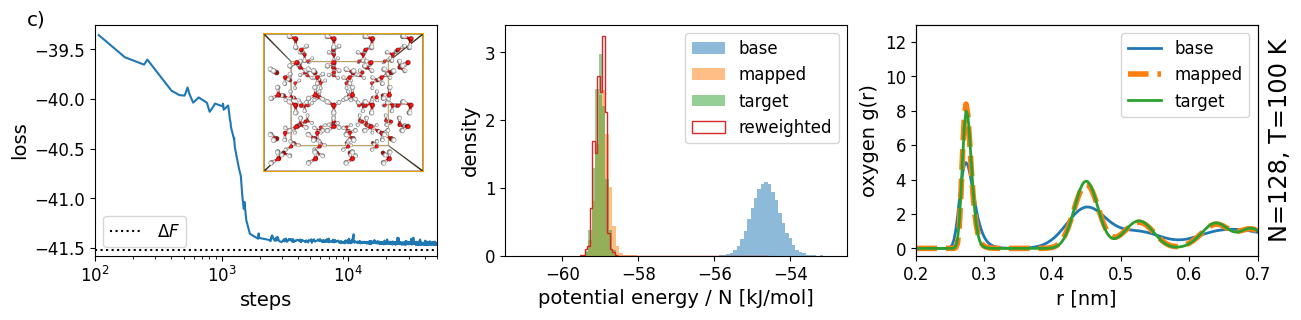

In [16]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plot_loss()

plt.subplot(1, 3, 2)
plot_energy()

plt.subplot(1, 3, 3)
plot_rdf()
ax = plt.gca().twinx()
ax.set_ylabel(f'N={model.n_waters}, T={specs.model.target.temperature} K', fontsize='x-large')
ax.set_yticks([])

filename = f'fig3-N{model.n_waters}_T{specs.model.target.temperature}.pdf'
plt.savefig(filename, bbox_inches='tight')
plt.show()

In [18]:
# ## store all useful data
# !bck.meup.sh {logdir_path}/{filename}
# !cp {filename} {logdir_path}/{filename}

# np.savez(
#     datafilename, 
#     base_ene=base_ene, 
#     mapped_ene=mapped_ene, 
#     target_ene=target_ene, 
#     weights=weights, 
#     base_pos=base_pos, 
#     mapped_pos=mapped_pos, 
#     target_pos=target_pos
# )

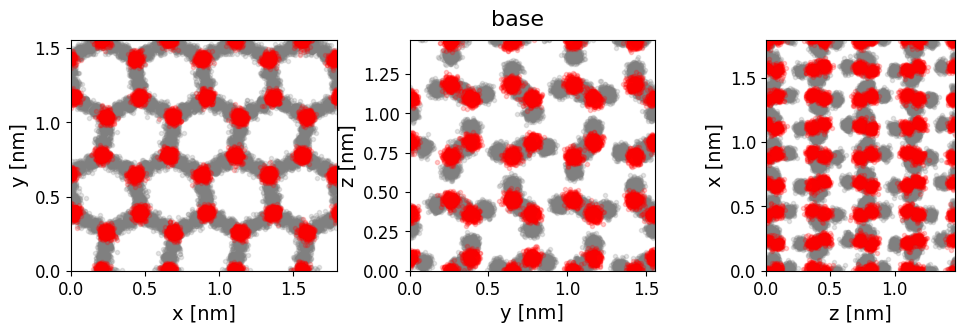

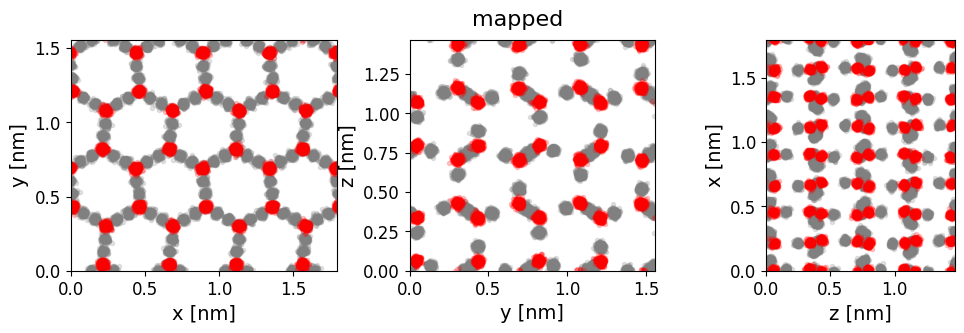

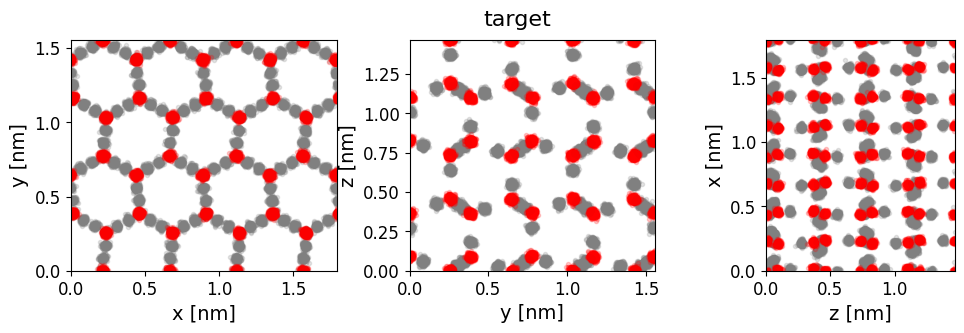

In [222]:
def plot_proj(pos, title='', marker='.', alpha=0.2, av_box=model.box):
    mypos = pos % np.diagonal(av_box)
    plt.figure(figsize=(12, 3))
    plt.suptitle(title)
    for i in range(3):
        ii = (i + 1) % 3
        iii = (i + 2) % 3
        plt.subplot(1, 3, 1 + i)

        # draw particles
        plt.scatter(
            mypos[..., 1 :: model.n_sites, i],
            mypos[..., 1 :: model.n_sites, ii],
            marker=marker,
            alpha=alpha,
            c="gray",
            rasterized=True
        )
        plt.scatter(
            mypos[..., 2 :: model.n_sites, i],
            mypos[..., 2 :: model.n_sites, ii],
            marker=marker,
            alpha=alpha,
            c="gray",
            rasterized=True
        )
        plt.scatter(
            mypos[..., :: model.n_sites, i],
            mypos[..., :: model.n_sites, ii],
            marker=marker,
            alpha=alpha,
            c="r",
            rasterized=True
        )

        def get_label(j):
            match j:
                case 0: 
                    return 'x'
                case 1:
                    return 'y'
                case 2:
                    return 'z'

        plt.xlabel(f"{get_label(i)} [nm]")
        plt.ylabel(f"{get_label(ii)} [nm]")
        plt.xlim(0, av_box[i,i])
        plt.ylim(0, av_box[ii,ii])
        plt.gca().set_aspect(1)
    # plt.show()

plot_proj(base_pos[::1000], 'base')
plt.savefig('ice_config-base.pdf', bbox_inches='tight')
plt.show()
plot_proj(mapped_pos[::1000], 'mapped')
plt.savefig('ice_config-mapped.pdf', bbox_inches='tight')
plt.show()
plot_proj(target_pos[::1000], 'target')
plt.savefig('ice_config-target.pdf', bbox_inches='tight')
plt.show()

# RENDERING STARTS HERE

In [26]:
from rigid_flows.systems.watermodel import WaterModel

temp = 100
water_type = 'tip4pew'
rigidWater = True
ice_type = 'XI'
n_waters = 128

# path = ''
path = '/group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/'
info = f'ice{ice_type}_T{temp}_N{n_waters}'
if water_type != 'tip4pew':
    info = f'{water_type}_{info}'
if not rigidWater:
    info = f'flex_{info}'
model = WaterModel.load_from_json(f'{path}model-{info}.json')
MDpos = np.load(f'{path}MDtraj-{info}.npz')['pos'][::1000] + np.diag(model.box) / 16


In [29]:
mask_vs = np.tile(np.concatenate((3*[True], (model.n_sites-3)*[False])), model.n_waters)
traj = model.get_mdtraj(MDpos[:,mask_vs], None, model.generate_mdtraj_topology(model.n_waters, 3))
traj.save_lammpstrj('test.dump')

In [4]:
import nglview as ngl

In [5]:
import jax
import jax.numpy as jnp

import numpy as np

import openmm
import openmm, openmm.app
from openmm import unit

kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

import mdtraj as md
import nglview as nv

from jax_dataclasses import pytree_dataclass

import flox

2023-01-30 15:48:28.560405: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-01-30 15:48:28.560626: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-01-30 15:48:28.560639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [225]:
#some useful stuff
def water_mdtraj_topology(n_waters, n_sites=3):
    H = md.element.Element.getBySymbol('H')
    O = md.element.Element.getBySymbol('O')
    VS = md.element.Element.getBySymbol('VS')
    water_top = md.Topology()
    for i in range(1):
        water_top.add_chain()
        for i in range(n_waters):
            water_top.add_residue('HOH', water_top.chain(0))
            water_top.add_atom('O', O, water_top.residue(i))
            water_top.add_atom('H1', H, water_top.residue(i))
            water_top.add_atom('H2', H, water_top.residue(i))
            if n_sites == 4:
                water_top.add_atom('M', VS, water_top.residue(i))
            water_top.add_bond(water_top.atom(n_sites*i), water_top.atom(n_sites*i+1))
            water_top.add_bond(water_top.atom(n_sites*i), water_top.atom(n_sites*i+2))
    return water_top


def get_view(data):
    
#     def process_positions(positions):
#         if len(positions.shape) == 3 and len(box.shape) == 1:
#             all_boxes = np.full((len(positions),len(box)), box)
#         else:
#             all_boxes = box
#         unitcell = {'unitcell_lengths' : all_boxes,
#                     'unitcell_angles' : np.full(all_boxes.shape, 90)}
#         return positions
    
    
#     data = process_positions(data)
#     samples = process_positions(samples)

    
        
        
#     data = preprocess(data)
#     samples = preprocess(samples)
    
#     data = data + np.array([-1.5, 0, 0])
#     samples = samples + np.array([1.5, 0, 0])
    positions = np.concatenate([data], 1)
    
    topo = water_mdtraj_topology(128, 4)
    
    view = nv.show_mdtraj(md.Trajectory(positions,topo))
#     view.add_unitcell()
    view.add_representation('ball+stick', selection="water")
    return view

class ModelWrapper():
    def __init__(self, system: openmm.System, mdtraj_topology: md.Topology, positions: np.ndarray):
        assert system.getNumParticles() == mdtraj_topology.n_atoms
        assert len(positions) == system.getNumParticles()
        self.system = system
        self.mdtraj_topology = mdtraj_topology
        self.topology = mdtraj_topology.to_openmm()
        self.positions = positions

In [226]:
# mapped_pos[::1000].shape

(100, 512, 3)

In [6]:
from flox.geom import canonical_rotation

rot = canonical_rotation(0/ 180 * jnp.pi, 1) #.reshape(-1)
    # mat = [float(v) for v in mat]
mat = jnp.eye(4)

mat = mat.at[:3, :3].set(rot)
mat = np.array(mat).reshape(-1).tolist()

def setup_view(pos):
    view = model.get_view(pos, virtualsites=False)

    

    # view.control.align(mat)
    # view.control.rotate([
    #     1, 0, 0, 0,
    #     0, 1, 0, 0,
    #     0, 0, 1, 0,
    #     0, 0, 0, 1,
    # ])
    # view.control.translate([0., -5., 0.])


    # view.control.orient(mat)

#     camera_type = "orthographic" # 
    camera_type = "perspective"
    view.parameters = dict(cameraType=camera_type, backgroundColor='white')
    view.control.center(np.diag(model.box) * 5)
    view.control.apply_matrix(mat)
    view.control.zoom(-2)
    # view.control.rotate(mat)
    # view.control.spin(vector, 0.1)

    return view

In [7]:

def preprocess(x):
    mean = jnp.mean(x, axis=1, keepdims=True)
    x = x - mean

    from flox.geom import canonical_rotation

    num_frames = x.shape[0]

    for i, t in enumerate(jnp.linspace(0, jnp.pi, num_frames)):
        rot = canonical_rotation(t, 1)
        x = x.at[i].set(x[i] @ rot)

    x = x + mean
    return np.array(x)

# initialize a view either for target or sample pos

In [8]:
# target_pos = pos + np.diag(model.box)/16

In [9]:
pos = preprocess(target_pos[::1000])
view = setup_view(pos)

In [10]:
view

NGLWidget(max_frame=99)

In [11]:
import numpy as np
from io import BytesIO
from PIL import Image

def png_bytes_to_numpy(png):
    """Convert png bytes to numpy array
    
    Example:  
    
    >>> fig = go.Figure(go.Scatter(x=[1], y=[1]))
    >>> plt.imshow(png_bytes_to_numpy(fig.to_image('png')))
    """
    return np.array(Image.open(BytesIO(png)))

In [12]:

import time
from time import sleep

from threading import Thread


class RenderThread(Thread):
    
    def __init__(self):
        super().__init__()
        self.result = []
        
    def run(self):
        
        for i in range(100):
            img = view.render_image(i, trim=False, factor=1)
            while not img.value:
                sleep(0.01)
            self.result.append(png_bytes_to_numpy(img.value))

        


In [13]:
t = RenderThread()

In [14]:
t.start()

### refresh line until all images have been rendered (yes that is ugly af)

In [21]:
print(len(t.result))

100


### store into corresponding value

In [22]:
target = t.result

### do the same for the samples

In [23]:
# samples = t.result

### merge both into the same image

In [24]:
from PIL import Image, ImageDraw

def process_frame(target, samples):
#     print(target.shape, samples.shape)
    joint = np.concatenate([
        np.transpose(target, [1, 0, 2])[300:-300],
        np.transpose(samples, [1, 0, 2])[300:-300],
    ], axis=1)
    joint = np.ascontiguousarray(joint)
    img = Image.fromarray(np.uint8(joint))
    img = img.convert('RGB')
    draw = ImageDraw.Draw(img)

    # font = ImageFont.load_default()
    # font = ImageFont.truetype("arial.ttf", fontsize)
    draw.text((20, 10), "data", fill="black")
    draw.text((320, 10), "sample", fill="black")
    return np.array(img)
#     return png_bytes_to_numpy(joint)
    


frames = [
    process_frame(t, s)   
    for t, s in zip(target, samples)
]

NameError: name 'samples' is not defined

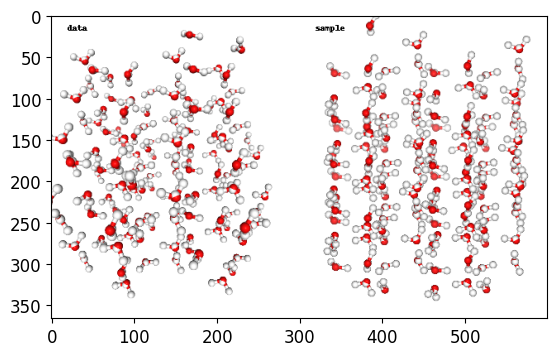

In [410]:
plt.imshow(frames[20])

### Render GIF

In [354]:
import imageio
from tqdm.notebook import tqdm 

with imageio.get_writer('/group/ag_cmb/scratch/jonkhler/foo.gif', mode='I') as writer:
    for img in tqdm(joint):
        writer.append_data(img)

  0%|          | 0/100 [00:00<?, ?it/s]